
# Project: PyTorch Hyperparameter Tuning

This project tunes the hyperparameters of a simple feedforward network using Optuna. Optuna uses a configurable algorithm to search for a best model. By default it uses a Bayesian optimization algorithm called [Tree-structured Parzen Estimator algorithm](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html).

The data used for this experiment is the Abalone Dataset and it can be found [here](https://www.kaggle.com/competitions/playground-series-s4e4/overview).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/projects/models/PyTorch

Mounted at /content/drive
/content/drive/MyDrive/projects/models/PyTorch


## Load The Data

In [ ]:
import pandas as pd

data = pd.read_csv("train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


## Prepare the data

The PyTorch model will use nn.Embedding for the categorical variables. The code below identifies the categorical and numeric variables.

In [ ]:
data.set_index('id',inplace=True)
y_col = ['Rings']
categorical_cols = ['Sex']
numeric_cols = [col for col in data.columns if col not in categorical_cols + y_col]
for cat in categorical_cols:
    data[cat] = data[cat].astype('category')

Calcualte embedding size for categorical varaiables.

In [ ]:
number_of_categories = [len(data[col].cat.categories) for col in categorical_cols]
#Using rule-of-thumb categorical embedding dimension limted smaller of
# 50 and half the number of categories.
embeddings_size = [(size, min(50, (size+1)//2)) for size in number_of_categories]

Standardize numeric columns.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch

cats = np.stack([data[col].cat.codes.values for col in categorical_cols], 1)
categorical_train = torch.tensor(cats, dtype=torch.int64)

nums = np.stack([data[col].values for col in numeric_cols], 1)
nums = StandardScaler().fit_transform(nums)
numeric_train = torch.tensor(nums, dtype=torch.float)

X = torch.cat([categorical_train, numeric_train], 1)
y = torch.tensor(data[y_col].values, dtype=torch.float).reshape(-1,1)

## Define The Model

A feedforward network with a configurable number of layers is defined below.

Embeddings for the categorical variables are created within the model.

In [ ]:
import torch.nn as nn

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class BaseFFModel(nn.Module):

    def __init__(self, embedding, number_of_numeric_flds, output_size,
                 layer_nodes, numeric_start_idx, drop_prob=0.0):
        super().__init__()

        self.numeric_start_idx = numeric_start_idx

        self.embeds = nn.ModuleList([nn.Embedding(ni, nf).to(device) for ni,nf in embedding])
        self.bn_cont = nn.BatchNorm1d(number_of_numeric_flds).to(device)
        self.emb_drop = nn.Dropout(drop_prob).to(device)

        n_emb = sum((nf for ni,nf in embedding))
        n_in = n_emb + number_of_numeric_flds

        layerlist = []
        for i in layer_nodes:
            layerlist.append(nn.Linear(n_in,i).to(device))
            layerlist.append(nn.ReLU(inplace=True).to(device))
            layerlist.append(nn.BatchNorm1d(i).to(device))
            layerlist.append(nn.Dropout(drop_prob).to(device))
            n_in = i
        layerlist.append(nn.Linear(n_in,output_size).to(device))

        self.layers = nn.Sequential(*layerlist).to(device)

    def forward(self, _X):
        x_cat = _X[:,:self.numeric_start_idx].long()
        x_cont = _X[:,self.numeric_start_idx:]
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)

        x = self.layers(x)

        return x


Lets train the model using a single set of hyperparameters.

epoch: 1  loss:   9.797086, eval RMSE loss:  10.034794
epoch: 18  loss:   7.926135, eval RMSE loss:   8.403334
epoch: 35  loss:   2.547741, eval RMSE loss:   2.558164
epoch: 52  loss:   1.882189, eval RMSE loss:   1.923794
epoch: 69  loss:   1.856223, eval RMSE loss:   1.920793
epoch: 86  loss:   1.855199, eval RMSE loss:   1.923764
epoch: 103  loss:   1.844636, eval RMSE loss:   1.910212
epoch: 120  loss:   1.840841, eval RMSE loss:   1.912971
epoch: 137  loss:   1.842885, eval RMSE loss:   1.904854
epoch: 154  loss:   1.835643, eval RMSE loss:   1.901876
epoch: 171  loss:   1.836623, eval RMSE loss:   1.912930
epoch: 188  loss:   1.830993, eval RMSE loss:   1.906131
epoch: 205  loss:   1.848268, eval RMSE loss:   1.903700
epoch: 222  loss:   1.828455, eval RMSE loss:   1.912006
epoch: 239  loss:   1.830164, eval RMSE loss:   1.905834
epoch: 256  loss:   1.825186, eval RMSE loss:   1.905095
epoch: 273  loss:   1.828314, eval RMSE loss:   1.905900
epoch: 290  loss:   1.823450, eval RMS

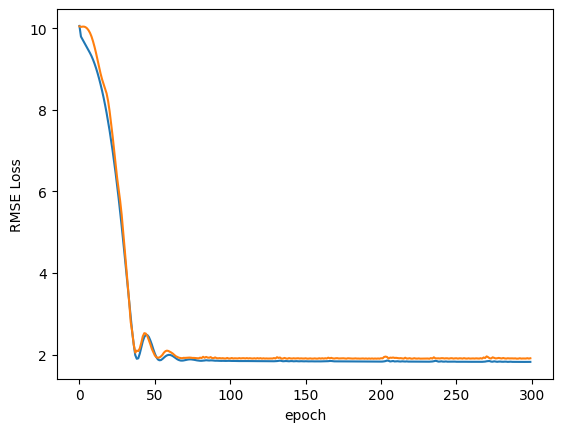

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import mean_squared_log_error

X_gpu = X.to(device)
y_gpu = y.to(device)

X_train, X_valid, y_train, y_valid = train_test_split(X_gpu, y_gpu, test_size=0.1, random_state=42)

model = BaseFFModel(embeddings_size, numeric_train.shape[1], 1, [100, 50], 1, 0.0)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 300
batch_size=X_train.shape[0]
losses = []
eval_losses = []

start_time = time.time()

for epoch in range(epochs):

    _X, _y = shuffle(X_train, y_train, n_samples=batch_size, random_state=42)

    model.train()
    optimizer.zero_grad()
    y_pred = model(_X)
    loss = torch.sqrt(criterion(y_pred, _y))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      eval_pred = model(X_valid)
      eval_loss = torch.sqrt(criterion(eval_pred, y_valid))
      eval_losses.append(eval_loss.item())

    if epoch%(epochs//np.sqrt(epochs)) == 1:
      print(f'epoch: {epoch}  loss: {losses[-1]:10.6f}, eval RMSE loss: {eval_losses[-1]:10.6f}')


print(f'Final Epoch: {i:3}  loss: {eval_loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

plt.plot(range(epochs), losses)
plt.plot(range(epochs), eval_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Optuna Hyperparameter Tuning

First the module is installed.

In [ ]:
!pip install -qU optuna --progress-bar off


Then we define the components needed for Optuna to optimze the model.

* A model defintion - A method the create a model using suggested hyperparameters.
* An objective function - A fuction that returns the criterion which Optuna will judge which model's configuration is better.

Below, I attempt to optimize the hyperparameters for learning rate, number and size of network layers, dropout, epochs, and the optimizer.


In [ ]:
import os

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

layer_map = {"A": (200, 100, 50), "B": (200, 100), "C": [100, 50], "D": (20, 10)}

def define_model(trial):
    """
    A model for a trail is created.
    """

    n_layers = trial.suggest_categorical("n_layers", ['A', 'B', 'C', 'D'])
    drop = trial.suggest_float("drop", 0, .8, step=0.1)

    model = BaseFFModel(embeddings_size, numeric_train.shape[1], 1, layer_map[n_layers], 1, drop)

    trial.set_user_attr(key="best_model_tmp", value=model)

    return model

def callback(study, trial):
    """
    A callback to keep track of the best model.
    """
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model_tmp"])


def objective(trial):
    """
    The objective function, which in this case will be minimized.
    """
    model = define_model(trial).to(device)

    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
    epochs = trial.suggest_int("epochs", 100, 500, step=10)

    batch_size= X_train.shape[0]
    criterion = nn.MSELoss()
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    start_time = time.time()
    for epoch in range(epochs):

        _X, _y = shuffle(X_train, y_train, n_samples=batch_size, random_state=42)

        model.train()
        optimizer.zero_grad()
        y_pred = model(_X)
        loss = torch.sqrt(criterion(y_pred, _y)) # RMSE
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
          eval_pred = model(X_valid)
          eval_loss = torch.sqrt(criterion(eval_pred, y_valid))

        trial.report(eval_loss, epoch)

        # Pruning based on the intermediate value.
        if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return eval_loss

Below the Optuna "study" is created and the "trails" run.  

* Study - This runs the optimization.
* Trial - A single trial of hyperparameters suggested by Optuna.

Part of the utility in using Optuna is that when trails that are not promising are encountered, they are aborted prior to finishing all their epochs.

For this experiment, 1000 trials are run.

I set the logging to `WARN`, otherwise many pruned `INFO` messages are displayed.

In [ ]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARN)

study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=1000, timeout=600, callbacks=[callback])

CPU times: user 3min 2s, sys: 1.03 s, total: 3min 3s
Wall time: 3min 19s


The study is complete. Below the results are reported.

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

best_model=study.user_attrs["best_model"]
eval_pred = best_model(X_valid)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    if key == "n_layers":
      print("    {}: {}".format(key, layer_map[value]))
    else: print("    {}: {}".format(key, value))


Study statistics: 
  Number of finished trials:  1000
  Number of pruned trials:  976
  Number of complete trials:  24
Best trial:
  Value:  1.8952199220657349
  Params: 
    n_layers: (200, 100)
    drop: 0.30000000000000004
    optimizer: Adam
    lr: 0.07564138502113096
    epochs: 460


This is a slight improvement over the single training done above without Optuna, but an improvement none the less.